In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct
%matplotlib inline

In [2]:
class ImageLoader:
    def __init__(self,FILE_PATH):
            self.img = np.array(Image.open(FILE_PATH))
            
    def get_points(self,POINT):
        Row = random.randint(0,len(self.img)-POINT-1)
        Col = random.randint(0,len(self.img)-1)
        return self.img[Row:Row+POINT,Col]
    
    # ランチョスしたのを返す
    def Lanczos(self,data):
        points = len(data)
        left = int(data[0])
        right = int(data[len(data)-1])

        result = np.zeros(points)
        for i in range(points):
            result[i] = data[i] - ((right-left)*i/(points-1) + left)
            
        return result
    
    def get_data_lanczos(self,POINT):
        return self.Lanczos(self.get_points(POINT))

In [3]:
def get_data_simple_connect(data):
    return np.hstack((data,data))

In [4]:
def get_data_even_connect(data):
    return np.hstack((data,data[::-1]))

In [5]:
class DCT:
    def __init__(self,N):
        self.N = N # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([ self.phi(i) for i in range(self.N)])
                
    def phi(self,k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N)/np.sqrt(self.N)
        else:
            return np.sqrt(2.0/self.N)*np.cos((k*np.pi/(2*self.N))*(np.arange(self.N)*2+1))
        
    def dct(self,data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self,c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum( self.phi_1d.T * c)

In [6]:
# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams['font.family'] ='Source Han Sans JP' #使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 12 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意

In [7]:
AIRPLANE   = ImageLoader("Mono/Airplane.bmp")
BARBARA    = ImageLoader("Mono/BARBARA.bmp")
BOAT       = ImageLoader("Mono/BOAT.bmp")
BRIDGE     = ImageLoader("Mono/BRIDGE.bmp")
BUILDING   = ImageLoader("Mono/Building.bmp")
CAMERAMAN  = ImageLoader("Mono/Cameraman.bmp")
GIRL       = ImageLoader("Mono/girl.bmp")
LAX        = ImageLoader("Mono/LAX.bmp")
LENNA      = ImageLoader("Mono/LENNA.bmp")
LIGHTHOUSE = ImageLoader("Mono/Lighthouse.bmp")
TEXT       = ImageLoader("Mono/Text.bmp")
WOMAN      = ImageLoader("Mono/WOMAN.bmp")

In [8]:
Images = np.array(
    [
        AIRPLANE,BARBARA,BOAT,
        BRIDGE,BUILDING,CAMERAMAN,
        GIRL,LAX,LENNA,
        LIGHTHOUSE,TEXT,WOMAN
    ]
)

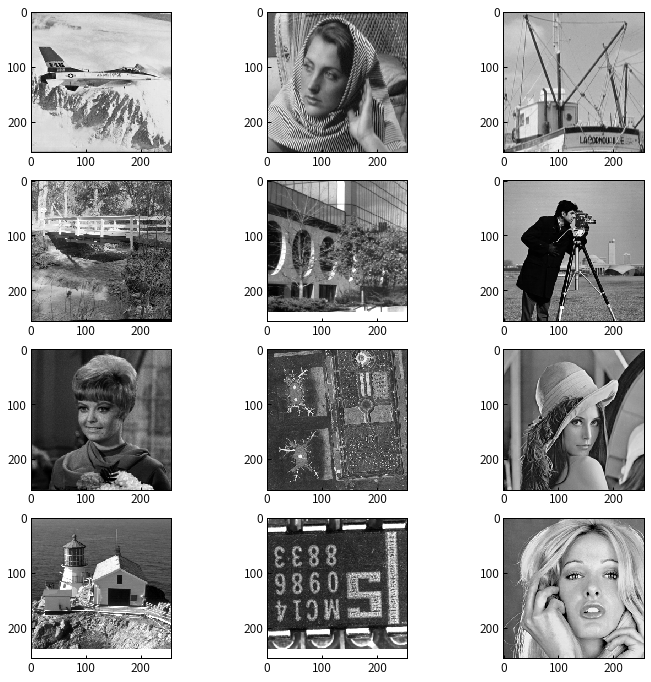

In [9]:
fig = plt.figure(figsize=(12,15))
for i in range(0,len(Images)):
    plt.subplot(len(Images)//3 + 1, 3 ,i+1)
    plt.imshow(Images[i].img,"gray")

# AIRPLANE

## DCT

In [10]:
N = 16
dct = DCT(N)
LOOP_COUNT = 10000
img_F_DCT = np.zeros(N)
for i in tqdm(range(LOOP_COUNT)):
#     data = LENNA.get_points(N//2)
#     img_F_DCT += abs(dct.dct(get_data_even_connect(data)))
    img_F_DCT += abs(dct.dct(LENNA.get_points(N)))
    
img_F_DCT /= LOOP_COUNT

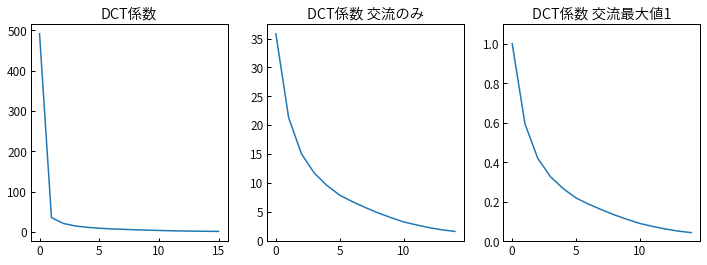

In [11]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(img_F_DCT)
ax1.title.set_text("DCT係数")

ax2 = fig.add_subplot(132)
ax2.plot(img_F_DCT[1:])
ax2.title.set_text("DCT係数 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.plot(img_F_DCT[1:]/img_F_DCT[1:].max())
ax3.title.set_text("DCT係数 交流最大値1")

# FFT

In [28]:
N=32
LOOP_COUNT = 1000000
img_F_FFT = np.zeros(N).astype(np.complex128)

for i in tqdm(range(LOOP_COUNT)):
#     img_F_FFT += np.fft.fft(LENNA.get_points(N))
    data = get_data_even_connect(LENNA.get_points(N//2))
    img_F_FFT += np.fft.fft(data)
    
img_F_FFT /= LOOP_COUNT

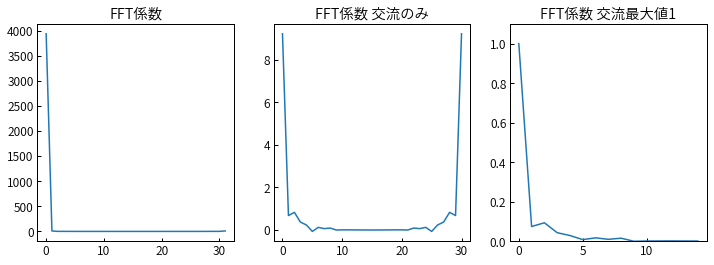

In [29]:
N = 32
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(img_F_FFT)
ax1.title.set_text("FFT係数")

ax2 = fig.add_subplot(132)
ax2.plot(img_F_FFT[1:])
ax2.title.set_text("FFT係数 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.title.set_text("FFT係数 交流最大値1")

img_F_FFT_1 = np.zeros(N//2-1)
for i in range(N//2-1):
    # 絶対値 sqrt(R^2 + I^2)
    img_F_FFT_1[i] = np.sqrt((img_F_FFT[i+1].real)**2 + (img_F_FFT[i+1].imag)**2)

ax3.plot(img_F_FFT_1/img_F_FFT_1.max())

In [30]:
N=32
LOOP_COUNT = 1000000
img_F_FFT_2 = np.zeros(N).astype(np.complex128)

for i in tqdm(range(LOOP_COUNT)):
#     img_F_FFT += np.fft.fft(LENNA.get_points(N))
    data = get_data_simple_connect(LENNA.get_points(N//2))
    img_F_FFT_2 += np.fft.fft(data)
    
img_F_FFT_2 /= LOOP_COUNT

/home/hiroya/Documents/Jupyter-Notebook/.venv/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


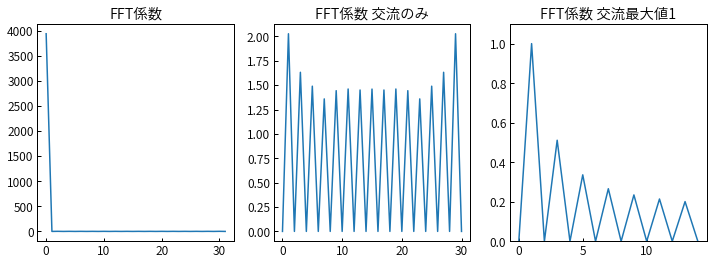

In [31]:
N = 32
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(img_F_FFT_2)
ax1.title.set_text("FFT係数")

ax2 = fig.add_subplot(132)
ax2.plot(img_F_FFT_2[1:])
ax2.title.set_text("FFT係数 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.title.set_text("FFT係数 交流最大値1")

img_F_FFT_3 = np.zeros(N//2-1)
for i in range(N//2-1):
    # 絶対値 sqrt(R^2 + I^2)
    img_F_FFT_3[i] = np.sqrt((img_F_FFT_2[i+1].real)**2 + (img_F_FFT_2[i+1].imag)**2)

ax3.plot(img_F_FFT_3/img_F_FFT_3.max())

In [36]:
img_F_FFT1_sum = img_F_FFT[0].real**2 + img_F_FFT[0].imag**2
img_F_FFT3_sum = img_F_FFT_2[0].real**2 + img_F_FFT_2[0].imag**2
for F in img_F_FFT_1:
    img_F_FFT1_sum += F**2

for F in img_F_FFT_3:
    img_F_FFT3_sum += F**2
    
print(img_F_FFT1_sum)
print(img_F_FFT3_sum)

15513990.57536234
15522677.469535429


# DCT + ランチョス

In [101]:
N = 16
LOOP_COUNT = 10000
img_F_DCT_L = np.zeros(N)
for i in tqdm(range(LOOP_COUNT)):
    data = LENNA.get_data_lanczos(N//2)
    img_F_DCT_L += abs(dct.dct(get_data_even_connect(data)))
    
img_F_DCT_L /= LOOP_COUNT

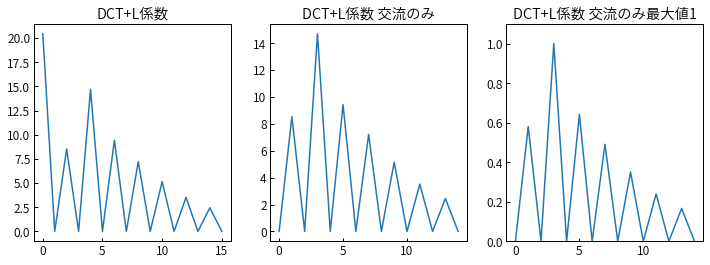

In [102]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(img_F_DCT_L)
ax1.title.set_text("DCT+L係数")

ax2 = fig.add_subplot(132)
ax2.plot(img_F_DCT_L[1:])
ax2.title.set_text("DCT+L係数 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.plot(img_F_DCT_L[1:]/img_F_DCT_L[1:].max())
ax3.title.set_text("DCT+L係数 交流のみ最大値1")

# FFT + ランチョス

In [52]:
N = 16
LOOP_COUNT = 10000
img_F_FFT_L = np.zeros(N).astype(np.complex128)

for i in tqdm(range(LOOP_COUNT)):
    img_F_FFT_L += np.fft.fft(LENNA.get_points_lanczos(N))
    
img_F_FFT_L /= LOOP_COUNT

/home/hiroya/Documents/Jupyter-Notebook/.venv/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


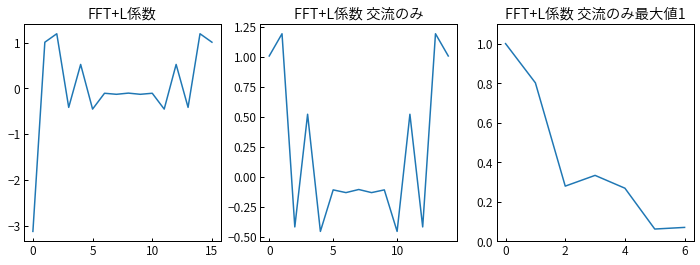

In [53]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(img_F_FFT_L)
ax1.title.set_text("FFT+L係数")

ax2 = fig.add_subplot(132)
ax2.plot(img_F_FFT_L[1:])
ax2.title.set_text("FFT+L係数 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
img_F_FFT_L_1 = np.zeros(8-1)
for i in range(8-1):
    img_F_FFT_L_1[i] = np.sqrt((img_F_FFT_L[i+1].real)**2 + (img_F_FFT_L[i+1].imag)**2)

ax3.plot(img_F_FFT_L_1/img_F_FFT_L_1.max())
ax3.title.set_text("FFT+L係数 交流のみ最大値1")

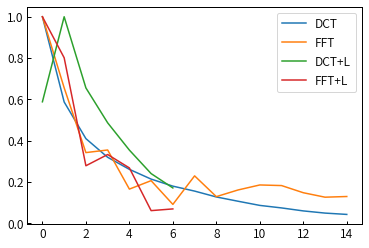

In [97]:
plt.plot(img_F_DCT[1:]/img_F_DCT[1:].max(),label="DCT")
plt.plot(img_F_FFT_1/img_F_FFT_1.max(),label="FFT")
plt.plot(img_F_DCT_L[1:]/img_F_DCT_L[1:].max(),label="DCT+L")
plt.plot(img_F_FFT_L_1/img_F_FFT_L_1.max(),label="FFT+L")
plt.legend()